In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
# from models import BrainNetwork, BrainDiffusionPrior, Voxel2StableDiffusionModel

seed=42
utils.seed_everything(seed=seed)

# Load CLIP extractor
from models import Clipper
clip_extractor = Clipper("ViT-L/14", hidden_state=True, refine=False, norm_embs=True, device=device)

device: cuda
ViT-L/14 cuda


## Precompute CLIP embeddings of all images

In [ ]:
# train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
# val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
# meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
# num_train = 8559 + 300
# num_val = 982
# val_batch_size = num_val
# voxels_key = 'nsdgeneral.npy' # 1d inputs

# batch_size = 300
# train_data = wds.WebDataset(train_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "coco")\
#     .batched(batch_size, partial=True)
# train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, shuffle=False)
# val_data = wds.WebDataset(val_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "coco")\
#     .batched(batch_size, partial=True)
# val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# train_clips = None
# for val_i, (voxel, image, coco) in enumerate(tqdm(train_dl,total=num_train//batch_size)):
#     clip = clip_extractor.embed_image(image).detach().cpu()
    
#     if train_clips is None:
#         train_clips = clip
#     else:
#         train_clips = torch.cat((train_clips, clip))
# np.save('train_clips_norm',train_clips.detach().cpu().numpy())

# val_clips = None
# for val_i, (voxel, image, coco) in enumerate(tqdm(val_dl,total=num_val//batch_size)):
#     clip = clip_extractor.embed_image(image).detach().cpu()
    
#     if val_clips is None:
#         val_clips = clip
#     else:
#         val_clips = torch.cat((val_clips, clip))
# np.save('val_clips_norm',val_clips.detach().cpu().numpy())

## Save numpy matrices of full training voxels and test voxels

In [ ]:
# batch_size = num_train
# train_data = wds.WebDataset(train_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "coco")\
#     .batched(batch_size, partial=True)
# train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, shuffle=False)
# val_data = wds.WebDataset(val_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "coco")\
#     .batched(val_batch_size, partial=True)
# val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)
# for i, (voxel, image, coco) in enumerate(train_dl):
#     voxel = torch.mean(voxel,axis=1)
#     print(i)
# np.save('train_voxels',voxel.detach().cpu().numpy())
# for i, (val_voxel, val_image, coco) in enumerate(val_dl):
#     val_voxel = torch.mean(val_voxel,axis=1)
#     print(i)
# np.save('val_voxels',val_voxel.detach().cpu().numpy())

## Train & predict with ridge regression on per-layer basis, then concatenate across layers
Copied over from https://github.com/ozcelikfu/brain-diffuser/blob/main/scripts/clipvision_regression.py

In [2]:
print("Training Regression")
# pred_clips = np.zeros((num_val,257,768))
pred_clips = np.load('pred_clips_norm.npy')
train_clips = np.load('train_clips_norm.npy')
val_clips = np.load('val_clips_norm.npy')
train_voxels = np.load('train_voxels.npy')
val_voxels = np.load('val_voxels.npy')

# I also ran this without the final norm step (aka norm_embs=False), so youd need to nn.functional.normalize(x, dim=-1) these outputs before feeding to VD
# pred_clips = np.load('pred_clips.npy')

print("train_clips",train_clips.shape)
print("val_clips",val_clips.shape)
print("pred_clips",pred_clips.shape)
print("train_voxels",train_voxels.shape)
print("val_voxels",val_voxels.shape)

## not doing these steps since our voxels are already session-wise standard scalar corrected
# train_voxels = train_voxels/300
# val_voxels = val_voxels/300
# norm_mean_train = np.mean(train_voxels, axis=0)
# norm_scale_train = np.std(train_voxels, axis=0, ddof=1)
# train_voxels = (train_voxels - norm_mean_train) / norm_scale_train
# val_voxels = (val_voxels - norm_mean_train) / norm_scale_train

# # commented out since i already ran this
# for i in range(257):
#     train_clip = train_clips[:,i]

#     reg = skl.Ridge(alpha=60000, max_iter=50000, fit_intercept=True)
#     reg.fit(train_voxels, train_clip)
    
#     pred_clips[:,i] = reg.predict(val_voxels)
    
#     std_norm_test_latent = (pred_test_latent - np.mean(pred_test_latent,axis=0)) / (np.std(pred_test_latent,axis=0)+1e-8)
#     pred_clips[:,i] = std_norm_test_latent * np.std(train_clip,axis=0) + np.mean(train_clip,axis=0)
    
# np.save('pred_clips_norm',pred_clips)

train_clips (8859, 257, 768)
val_clips (982, 257, 768)
pred_clips (982, 257, 768)
train_voxels (8859, 15724)
val_voxels (982, 15724)


# Reconstruction

## Load versatile diffusion dual-guidance variant

In [4]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler, Transformer2DModel
from diffusers.models import DualTransformer2DModel
from diffusers.pipelines.versatile_diffusion.modeling_text_unet import UNetFlatConditionModel

with torch.no_grad():
    sd_cache_dir = '/fsx/proj-medarc/fmri/cache/models--shi-labs--versatile-diffusion/snapshots/2926f8e11ea526b562cd592b099fcf9c2985d0b7'
    if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
        from diffusers import VersatileDiffusionPipeline
        print("Downloading from huggingface...")
        sd_pipe = VersatileDiffusionPipeline.from_pretrained("shi-labs/versatile-diffusion")
        sd_cache_dir = "shi-labs/versatile-diffusion"
    unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="image_unet").to(device)
    unet.eval() # dont want to train model
    unet.requires_grad_(False) # dont need to calculate gradients

    vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
    vae.eval()
    vae.requires_grad_(False)

    scheduler = "unipc" # "pndms" or "unipc"

    text_unet = UNetFlatConditionModel.from_pretrained(sd_cache_dir,subfolder="text_unet").to(device)
    text_unet.eval() # dont want to train model
    text_unet.requires_grad_(False) # dont need to calculate gradients

    noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
    if scheduler == "unipc":
        noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)
        num_inference_steps = 20
    else:
        num_inference_steps = 50

    # convert to dual attention         
    for name, module in unet.named_modules():
        if isinstance(module, Transformer2DModel):
            parent_name, index = name.rsplit(".", 1)
            index = int(index)

            image_transformer = unet.get_submodule(parent_name)[index]
            text_transformer = text_unet.get_submodule(parent_name)[index]

            config = image_transformer.config
            dual_transformer = DualTransformer2DModel(
                num_attention_heads=config.num_attention_heads,
                attention_head_dim=config.attention_head_dim,
                in_channels=config.in_channels,
                num_layers=config.num_layers,
                dropout=config.dropout,
                norm_num_groups=config.norm_num_groups,
                cross_attention_dim=config.cross_attention_dim,
                attention_bias=config.attention_bias,
                sample_size=config.sample_size,
                num_vector_embeds=config.num_vector_embeds,
                activation_fn=config.activation_fn,
                num_embeds_ada_norm=config.num_embeds_ada_norm,
            )
            dual_transformer.transformers[0] = image_transformer
            dual_transformer.transformers[1] = text_transformer

            unet.get_submodule(parent_name)[index] = dual_transformer
            unet.register_to_config(dual_cross_attention=True)
            
    # import logging
    # logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    # from transformers import CLIPTextModelWithProjection, CLIPTokenizer
    # tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    # text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
    # text_encoder.eval()
    # text_encoder.requires_grad_(False)

    # annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")
    
    text_image_ratio = .0 # .5 means equally weight text and image, 0 means only use image
    condition_types = ("text", "image")
    for name, module in unet.named_modules():
        if isinstance(module, DualTransformer2DModel):
            module.mix_ratio = text_image_ratio
            for i, type in enumerate(condition_types):
                if type == "text":
                    module.condition_lengths[i] = 77
                    module.transformer_index_for_condition[i] = 1  # use the second (text) transformer
                else:
                    module.condition_lengths[i] = 257
                    module.transformer_index_for_condition[i] = 0  # use the first (image) transformer

torch.Size([2, 257, 768])


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


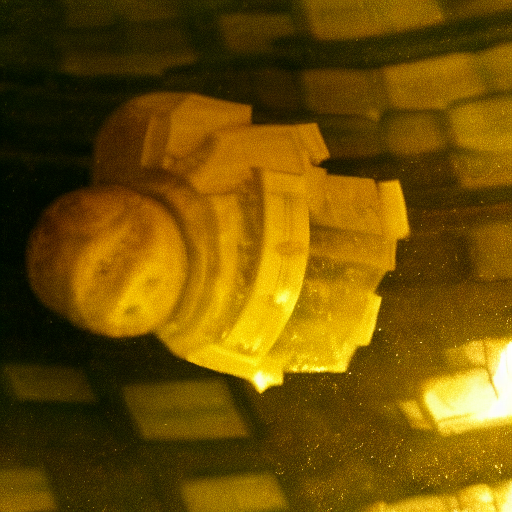

In [6]:
from diffusers.utils import randn_tensor
guidance_scale = 7.5
torch.manual_seed(0)
do_classifier_free_guidance = guidance_scale > 1.0
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

preproc = transforms.Compose([
            transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(size=224),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])

sample_index = 0
              
with torch.no_grad():
    input_embedding = torch.Tensor(pred_clips[[sample_index]]).to(device)

    input_embedding = torch.cat([torch.zeros_like(input_embedding), input_embedding]).to(device)
    print(input_embedding.shape)

    prompt_embeds = torch.randn(1,77,768).to(device)
    prompt_embeds = torch.cat([torch.zeros_like(prompt_embeds), prompt_embeds]).to(device)
    input_embedding = torch.cat([prompt_embeds, input_embedding], dim=1)

    noise_scheduler.set_timesteps(num_inference_steps=20, device=device)
    batch_size = input_embedding.shape[0] // 2 # divide by 2 bc we doubled it for classifier-free guidance
    shape = (batch_size, unet.in_channels, height // vae_scale_factor, width // vae_scale_factor)
    timesteps = noise_scheduler.timesteps
    latents = randn_tensor(shape, device=device, dtype=input_embedding.dtype)
    latents = latents * noise_scheduler.init_noise_sigma
    for i, t in enumerate(tqdm(timesteps)):
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=input_embedding).sample
        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
    recons = decode_latents(latents).detach().cpu()
utils.torch_to_Image(recons)